# Ciência de Dados 2

## Resultados encontrados

In [109]:
import warnings
import pandas as pd
import numpy as np
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import nltk
from ipywidgets import interactive
from IPython.display import clear_output 
from nltk.probability import FreqDist
from nltk.corpus import stopwords, wordnet as wn
from nltk.util import ngrams
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from matplotlib_venn import venn2, venn2_circles
from gensim import corpora
from gensim.models import LsiModel
from gensim.models.coherencemodel import CoherenceModel



warnings.filterwarnings('ignore')
sns.set_theme(style="whitegrid")

In [110]:
## Lendo os arquivos CSV para fazer o merge novamente.
df = pd.read_csv('datasets/covidCaseslimpo.csv', delimiter=",")
df.drop('Unnamed: 0', axis=1, inplace=True)
df.rename(columns={'city':'municipio',
                          'date':'data',
                          'estimated_population':'populacao',
                          'last_available_death_rate':'letalidade',
                          'state':'estado',
                          'new_confirmed':'confirmados',
                          'new_deaths':'obitos'}, 
                 inplace=True)

df["populacao"] = df["populacao"].astype('int64')

df_geral = pd.read_csv('datasets/covidCaseslimpoGeral.csv', delimiter=",")
df_geral.drop('Unnamed: 0', axis=1, inplace=True)
df_geral.rename(columns={'city':'municipio',
                          'date':'data',
                          'estimated_population':'populacao',
                          'last_available_death_rate':'letalidade',
                          'state':'estado',
                          'new_confirmed':'confirmados',
                          'new_deaths':'obitos'}, 
                 inplace=True)

df_geral["populacao"] = df_geral["populacao"].astype('int64')

In [111]:
# lê o arquivo CSV
df_twitter = pd.read_csv('datasets/PrefsTweetsLimpoStemmerSB.csv', delimiter=",")
df_twitter['final_tokens']=df_twitter['final_tokens'].str[1:-1].str.split(', ').tolist()
df_twitter['tokens']=df_twitter['tokens'].str[1:-1].str.split(', ').tolist()
df_twitter.drop('Unnamed: 0', axis=1, inplace=True)
df_twitter = df_twitter.dropna()

# lê o arquivo CSV
df_estados_merge = pd.read_csv('datasets/TwitterPrefeiturasCOVIDIO.csv', delimiter=";")

## Adicionado o estado no df do twitter tambem. 
df_merge_tt = pd.merge(df_twitter, df_estados_merge, left_on='municipio', right_on='Municipio')

df_merge_tt.drop('Data', axis=1, inplace=True)
df_merge_tt.drop('Municipio', axis=1, inplace=True)
df_merge_tt.drop('Confirmados', axis=1, inplace=True)
df_merge_tt.drop('Confirmados 100k habitantes', axis=1, inplace=True)
df_merge_tt.drop('Obitos', axis=1, inplace=True)
df_merge_tt.drop('Letalidade', axis=1, inplace=True)
df_merge_tt.drop('Obitos 100k habitantes', axis=1, inplace=True)
df_merge_tt.drop('perfil', axis=1, inplace=True)
df_merge_tt.drop('tweet_id', axis=1, inplace=True)

df_merge_tt.rename(columns={'UF':'estado',
                          'public_metrics_reply_count':'reply_count',
                          'public_metrics_retweet_count':'retweet_count',
                          'public_metrics_like_count':'like_count',
                          'public_metrics_quote_count':'quote_count'}, 
                 inplace=True)

df_merge_tt = df_merge_tt[['estado', 'municipio','created_at', 'text', 'tokens', 'tokens_frase', 'final_tokens', 'referenced_twitter', 'retweet_count', 'reply_count','like_count','quote_count' ]]
df_merge_tt['created_at'] = pd.to_datetime(df_merge_tt['created_at'])

df_cidades = df.groupby(['estado', 'municipio']).size().reset_index(name="Count")
df_cidades.drop('Count', axis=1, inplace=True)
df_cidades = df_cidades.groupby(['estado']).size().reset_index(name="Count")

list_estados = df_cidades.sort_values('Count', ascending=False)["estado"].reset_index()["estado"].head(10)
list_estados

0    SP
1    RJ
2    RS
3    PR
4    PE
5    PB
6    MG
7    SC
8    ES
9    MT
Name: estado, dtype: object

In [112]:
## Separando o dataset com tweets sobre covid e sobre outros assuntos
list_covid_terms = ["covid", 'vacinaca', "covid19", "vacin", "coron", "coronavirus","pandem", "quarenten", "cloroquin", "hidroxicloroquin", "azitromicin", "masc", "lockdown", "comorb"]

def check_covid_terms(tokens):  
    covid_term = 0;
    
    for word in tokens:
        covid_term = [True for match in list_covid_terms if match in word]
        if True in covid_term:
            covid_term = 1
            break;
    
    return covid_term

df_merge_tt['covid_terms'] = df_merge_tt['final_tokens'].apply(lambda x: check_covid_terms(x))
df_twitter_covid = df_merge_tt[df_merge_tt['covid_terms'] == 1]

### Conforme ja mencionado na Analise exploratoria o estado de MT é considerado um outlier então removo todos os tweets do estado do MT. 

In [113]:
### Removendo MT
df_twitter_covid = df_twitter_covid[df_twitter_covid['estado'] != 'MT']
df_merge_tt = df_merge_tt[df_merge_tt['estado'] != 'MT']

In [114]:
df_cidades = df.groupby(['estado', 'municipio']).size().reset_index(name="Count")
df_cidades.drop('Count', axis=1, inplace=True)
df_cidades = df_cidades.groupby(['estado']).size().reset_index(name="Count")

list_estados = df_cidades.sort_values('Count', ascending=False)["estado"].reset_index()["estado"].head(10)
df_merge_tt = df_merge_tt[df_merge_tt['estado'].isin(list_estados)]

# Hipóteses da pesquisa e seus resultados

## Agora que ja temos todos os datasets lidos vamos começar com as hipóteses da pesquisa: 

### 1. Prefeituras que fazem mais tweets sobre a COVID-19 tem número menor de casos confirmados/óbitos?

Text(0.5, 1.0, 'Ranking de cidades com MAIS tweets sobre COVID 19 por municipio - % ')

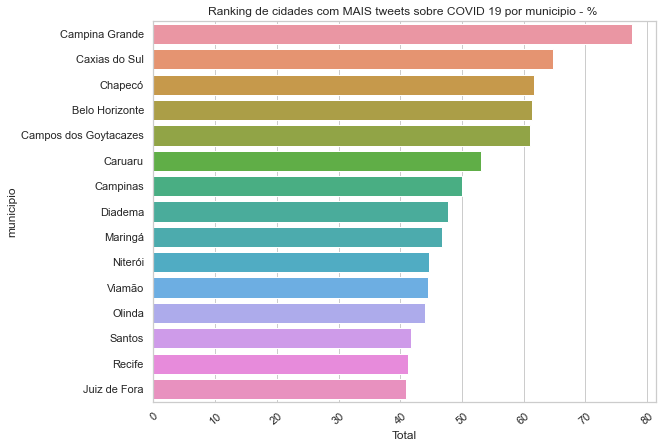

In [115]:
df_municipio_c = df_twitter_covid.groupby(['municipio']).size().reset_index(name="Count_c").sort_values('Count_c', ascending=False)
df_municipio = df_merge_tt.groupby(['municipio']).size().reset_index(name="Count").sort_values('Count', ascending=False)


## Adicionado o estado no df do twitter tambem. 
df_mun_merge = pd.merge(df_municipio, df_municipio_c, left_on='municipio', right_on='municipio')
df_mun_merge['percent_tweets_covid'] = (100*df_mun_merge['Count_c']) / df_mun_merge['Count']


f, ax = plt.subplots(figsize=(9,7))
ax = sns.barplot(x="percent_tweets_covid", y="municipio", order=df_mun_merge.sort_values('percent_tweets_covid', ascending=False)["municipio"].head(15), data=df_mun_merge, orient='h')
plt.xticks(rotation=40)
plt.xlabel("Total")
plt.title("Ranking de cidades com MAIS tweets sobre COVID 19 por municipio - % ")

Text(0.5, 1.0, 'Ranking de cidades que menos tweetam sobre COVID 19 por municipio - % ')

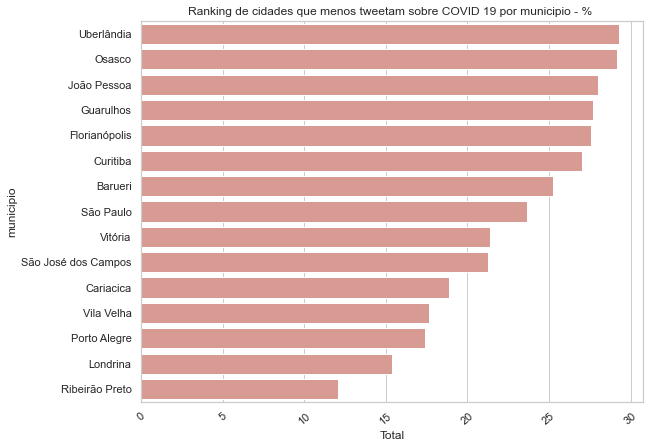

In [116]:
f, ax = plt.subplots(figsize=(9,7))
ax = sns.barplot(x="percent_tweets_covid", y="municipio", order=df_mun_merge.sort_values('percent_tweets_covid', ascending=False)["municipio"].tail(15), data=df_mun_merge, orient='h', color="salmon", saturation=.5)
plt.xticks(rotation=40)
plt.xlabel("Total")
plt.xlabel("Total")
plt.title("Ranking de cidades que menos tweetam sobre COVID 19 por municipio - % ")

Text(0.5, 1.0, 'Comparação de casos confirmados de COVID X Cidade que mais e menos twittam')

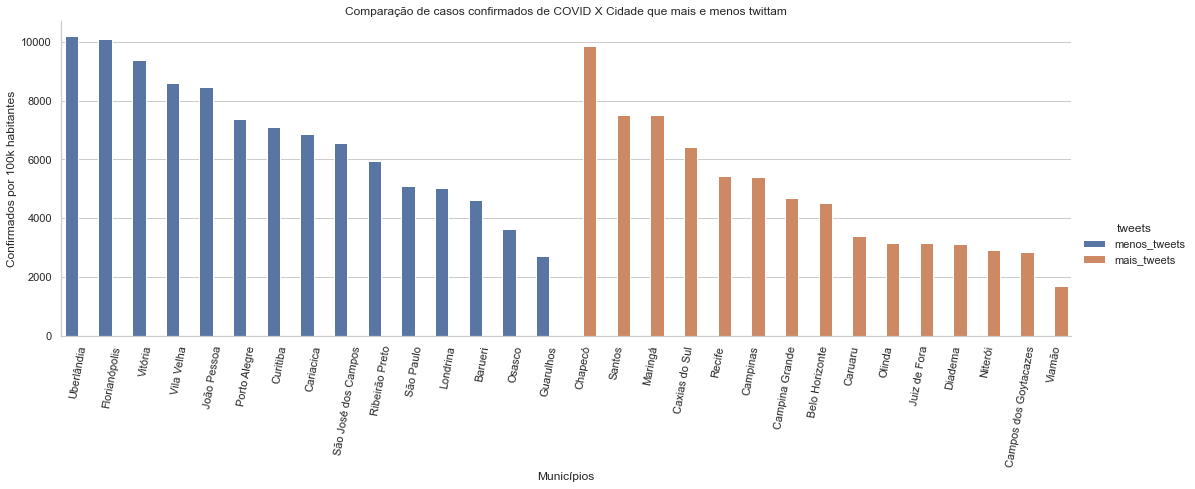

In [117]:
dfMaisMenosTweets = dfMaisMenosTweets.sort_values(["tweets", 'confirmados_100k'], ascending=False)

sns.factorplot(y='confirmados_100k', x='municipio', hue='tweets', data=dfMaisMenosTweets, kind='bar', ax=ax, height=5, aspect=3)
plt.xlabel("Municípios")
plt.ylabel("Confirmados por 100k habitantes")
plt.xticks(rotation=80)
plt.title("Comparação de casos confirmados de COVID X Cidade que mais e menos twittam")

Text(0.5, 1.0, 'Comparação de óbitos de COVID X Cidade que mais e menos twittam')

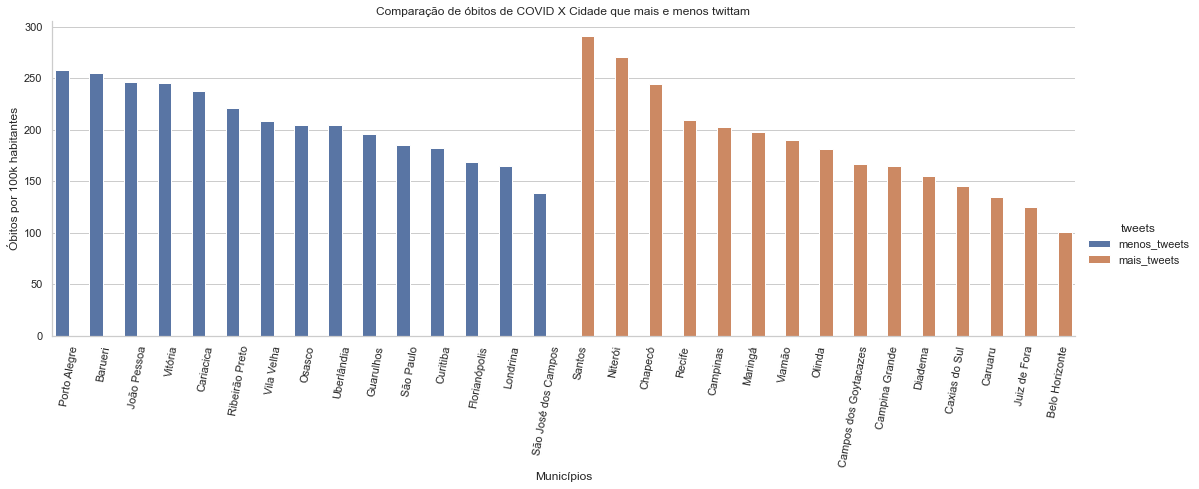

In [118]:
dfMaisMenosTweets = dfMaisMenosTweets.sort_values(["tweets", 'obitos_100k'], ascending=False)

sns.factorplot(y='obitos_100k', x='municipio', hue='tweets', data=dfMaisMenosTweets, kind='bar', ax=ax, height=5, aspect=3)
plt.xlabel("Municípios")
plt.ylabel("Óbitos por 100k habitantes")
plt.xticks(rotation=80)
plt.title("Comparação de óbitos de COVID X Cidade que mais e menos twittam")

In [119]:
# lê o arquivo CSV
df_tweets_por_confirmados = pd.read_csv('datasets/PrefsTweetsPorConfirmados.csv', delimiter=";")
df_tweets_por_confirmados.drop('Unnamed: 0', axis=1, inplace=True)
df_tweets_por_confirmados.drop('estado_y', axis=1, inplace=True)

df_tweets_por_confirmados.rename(columns={'estado_x':'estado', 'Count':'qtde_tweets', 'Count_c':'qtde_tweets_covid'}, 
                 inplace=True)

df_tweets_por_confirmados

estado              municipio  populacao  confirmados  obitos  \
0      ES              Cariacica     383917        26384     911   
1      ES                  Serra     527240        42189     974   
2      ES             Vila Velha     501325        43129    1046   
3      ES                Vitória     365855        34314     898   
4      MG         Belo Horizonte    2521564       113737    2545   
5      MG           Juiz de Fora     573285        18175     717   
6      MG             Uberlândia     699097        71294    1428   
7      PB         Campina Grande     411807        19331     680   
8      PB            João Pessoa     817511        69298    2015   
9      PE                Caruaru     365278        12398     490   
10     PE                 Olinda     393115        12466     714   
11     PE                 Recife    1653461        89796    3454   
12     PR               Curitiba    1948626       138449    3552   
13     PR               Londrina     575377        28853     946   
14     PR                Maringá     430157        32346     851   
15     RJ  Campos dos Goytacazes     511168        14576     853   
16     RJ        Duque de Caxias     924624        15524    1140   
17     RJ                Niterói     515317        15091    1394   
18     RJ            Nova Iguaçu     823302        11991    1165   
19     RJ         Rio de Janeiro    6747815       231304   21457   
20     RS                 Canoas     348208        25682    1097   
21     RS          Caxias do Sul     517451        33311     752   
22     RS          Novo Hamburgo     247032        16231     661   
23     RS                Pelotas     343132        16630     593   
24     RS           Porto Alegre    1488252       109977    3838   
25     RS                 Viamão     256302         4312     486   
26     SC                Chapecó     224013        22085     548   
27     SC          Florianópolis     508826        51457     858   
28     SC              Joinville     597658        71234    1093   
29     SP                Barueri     276982        12760     706   
30     SP               Campinas    1213792        65635    2463   
31     SP                Diadema     426757        13279     661   
32     SP              Guarulhos    1392121        37582    2728   
33     SP                Jundiaí     423006        26132     823   
34     SP        Mogi das Cruzes     450785        15689     915   
35     SP                 Osasco     699944        25322    1430   
36     SP         Ribeirão Preto     711825        42408    1572   
37     SP                 Santos     433656        32644    1261   
38     SP    São José dos Campos     729737        47950    1011   
39     SP              São Paulo   12325232       628363   22844   
40     SP            São Vicente     368355         9437     718   

    confirmados_100k  obitos_100k  qtde_tweets  qtde_tweets_covid  
0        6872.318756   237.290873          530                100  
1        8001.858736   184.735604          268                 94  
2        8603.002045   208.647085          215                 38  
3        9379.125610   245.452433          285                 61  
4        4510.573596   100.929423          189                116  
5        3170.325405   125.068683          806                330  
6       10198.012579   204.263500         2971                871  
7        4694.189268   165.125896          209                162  
8        8476.705512   246.479864         2638                739  
9        3394.127213   134.144405           32                 17  
10       3171.082253   181.626242           84                 37  
11       5430.790324   208.895160         2743               1131  
12       7104.954979   182.282285         2658                719  
13       5014.625194   164.413941         1849                284  
14       7519.580060   197.834744         1247                584  
15       2851.508702   166.872731          390            

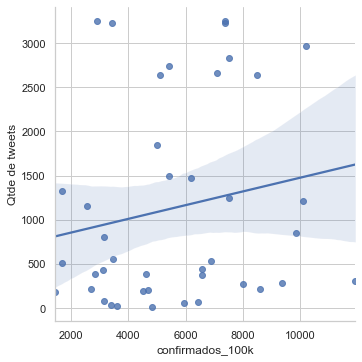

In [123]:
g = sns.lmplot(
    data=df_tweets_por_confirmados,
    x="confirmados_100k", y="qtde_tweets"
)

# Use more informative axis labels than are provided by default
g.set_axis_labels("confirmados_100k", "Qtde de tweets")

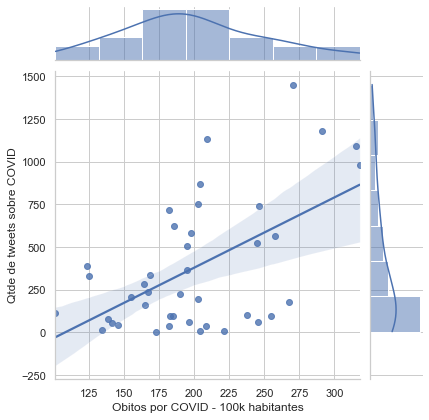

In [126]:
g = sns.jointplot(x="obitos_100k", y="qtde_tweets_covid", data=df_tweets_por_confirmados,
                  kind="reg")

g.set_axis_labels("Obitos por COVID - 100k habitantes", "Qtde de tweets sobre COVID")

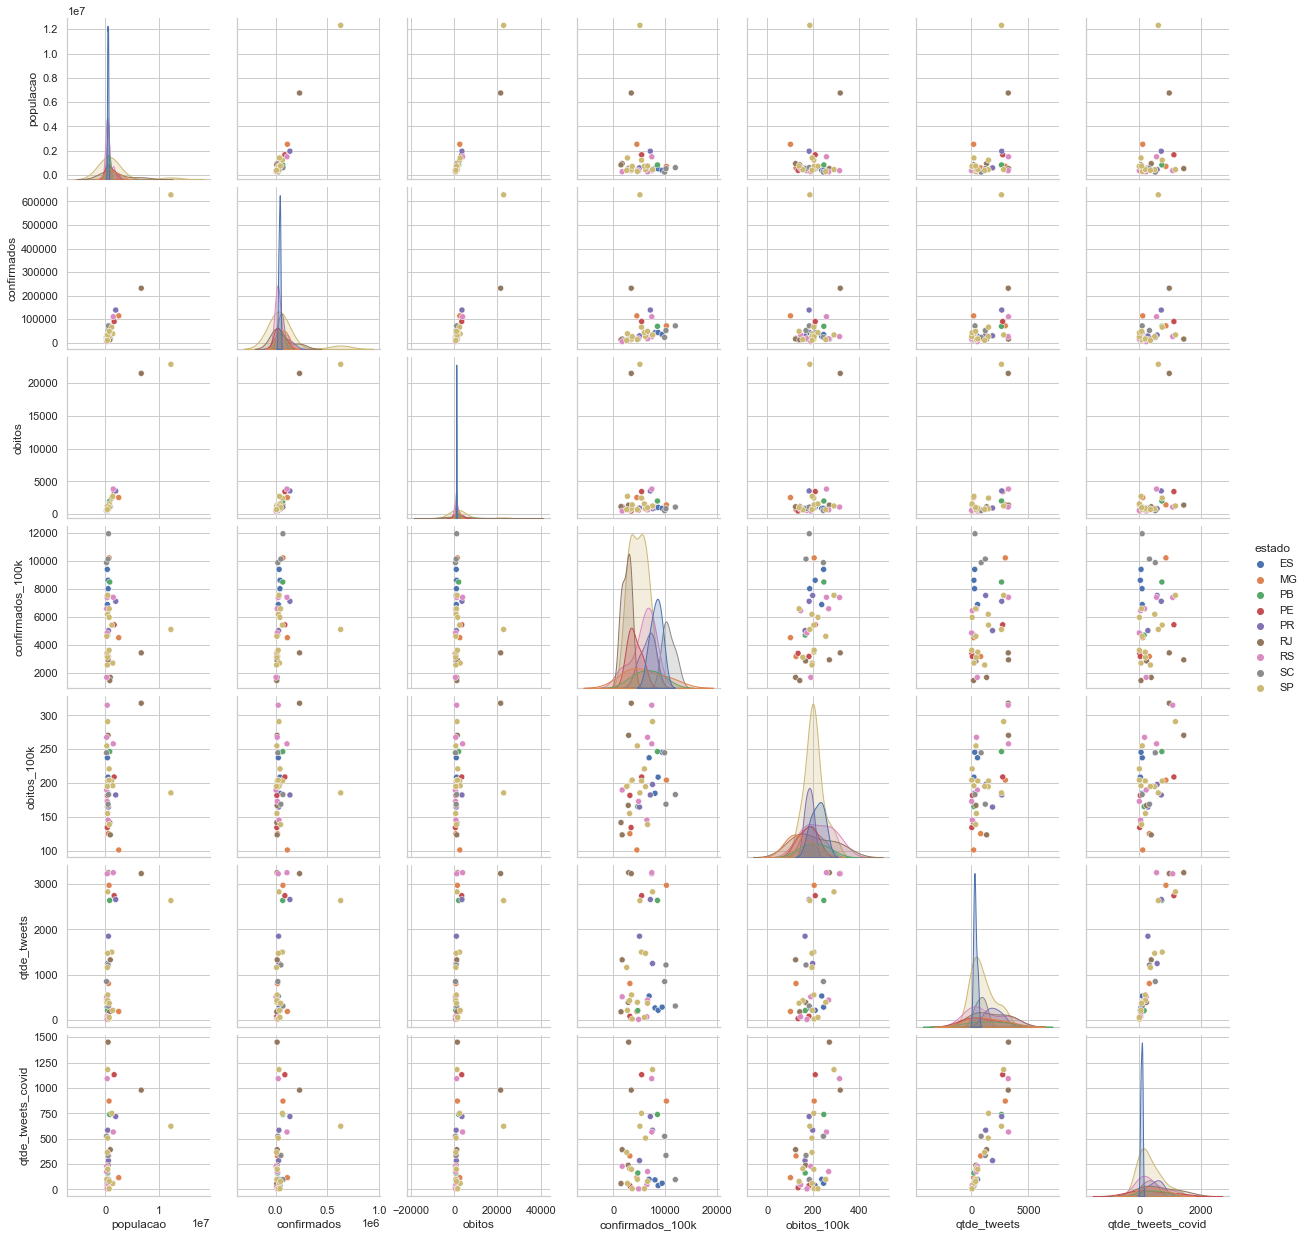

In [130]:
g = sns.pairplot(df_tweets_por_confirmados, hue="estado")

In [107]:
df_tweets_por_confirmados.corr()

populacao  confirmados    obitos  confirmados_100k  \
populacao           1.000000     0.971847  0.956465         -0.101485   
confirmados         0.971847     1.000000  0.891811          0.068200   
obitos              0.956465     0.891811  1.000000         -0.099315   
confirmados_100k   -0.101485     0.068200 -0.099315          1.000000   
obitos_100k         0.070933     0.063668  0.238296          0.292883   
qtde_tweets         0.371303     0.400505  0.439203          0.180244   
qtde_tweets_covid   0.238758     0.246857  0.310481          0.124172   

                   obitos_100k  qtde_tweets  qtde_tweets_covid  
populacao             0.070933     0.371303           0.238758  
confirmados           0.063668     0.400505           0.246857  
obitos                0.238296     0.439203           0.310481  
confirmados_100k      0.292883     0.180244           0.124172  
obitos_100k           1.000000     0.534480           0.546519  
qtde_tweets           0.534480     1.000000           0.917825  
qtde_tweets_covid     0.546519     0.917825           1.000000

<AxesSubplot:>

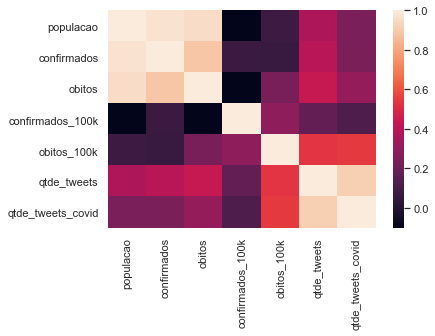

In [90]:
df_corr = df_tweets_por_confirmados.corr()
sns.heatmap(df_corr)

<AxesSubplot:>

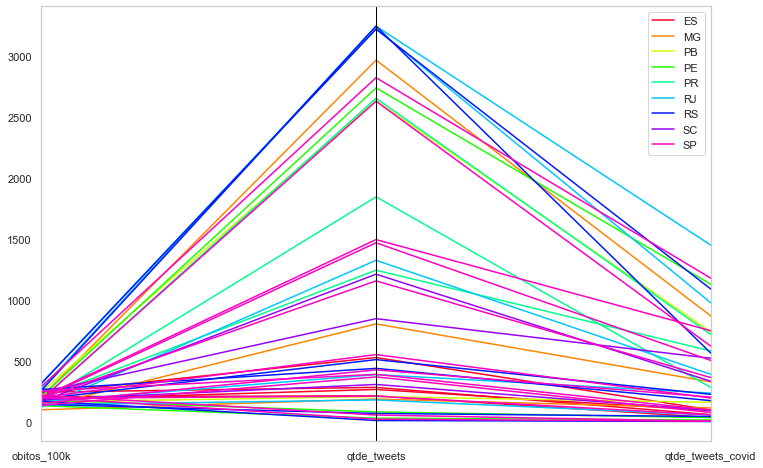

In [132]:
from pandas.plotting import parallel_coordinates

fig = plt.figure(figsize=(12,8))
parallel_coordinates(df_tweets_por_confirmados[['obitos_100k', 'qtde_tweets', 'qtde_tweets_covid','estado']], 'estado', colormap='gist_rainbow')

### Resposta: Olhando para os gráficos acima podemos concluir que municipios que possuem mais tweets sobre covid possuem um número menor de casos confirmados/óbitos e de obitos.

### 2. Existe uma diferença de mortalidade/casos confirmados de COVID-19 em cidades que se comunicam mais no Twitter do que aquelas que não se comunicam?

In [259]:
## Lista com as 10 cidades que estao entre os top 10 em obitos acumulados mas nao possuem conta no twitter
list_cidade_sem_twitter = ["Santo André", "Aparecida de Goiânia", "Contagem", "Piracicaba", "Guarujá", "Rondonópolis", "Feira de Santana", "Bauru", "Caucaia", "Teresópolis"]

df_mun_sem_twitter = df_geral[df_geral['municipio'].isin(list_cidade_sem_twitter)]


## Lista com top 10 cidades que mais se comunicam no twitter
df_cidades_twitter = dfMaisMenosTweets[dfMaisMenosTweets["tweets"] == "mais_tweets"].head(15)

total_cidade_sem_twitter = df_mun_sem_twitter.groupby(["municipio", "populacao"])["confirmados", "obitos"].sum().reset_index()
total_cidade_sem_twitter["confirmados_100k"] = total_cidade_sem_twitter['confirmados']/total_cidade_sem_twitter['populacao'] * 100000
total_cidade_sem_twitter["obitos_100k"] = (total_cidade_sem_twitter['obitos']/total_cidade_sem_twitter['populacao']) * 100000
total_cidade_sem_twitter = total_cidade_sem_twitter[["municipio", "confirmados_100k", "obitos_100k"]]
total_cidade_sem_twitter["tweets"] = "sem_tweets"

frames = [total_cidade_sem_twitter, df_cidades_twitter]
result = pd.concat(frames)

result.drop('Unnamed: 0', axis=1, inplace=True)

Text(0.5, 1.0, 'Comparação entre top cidades que mais tweetam com cidades sem conta no twitter')

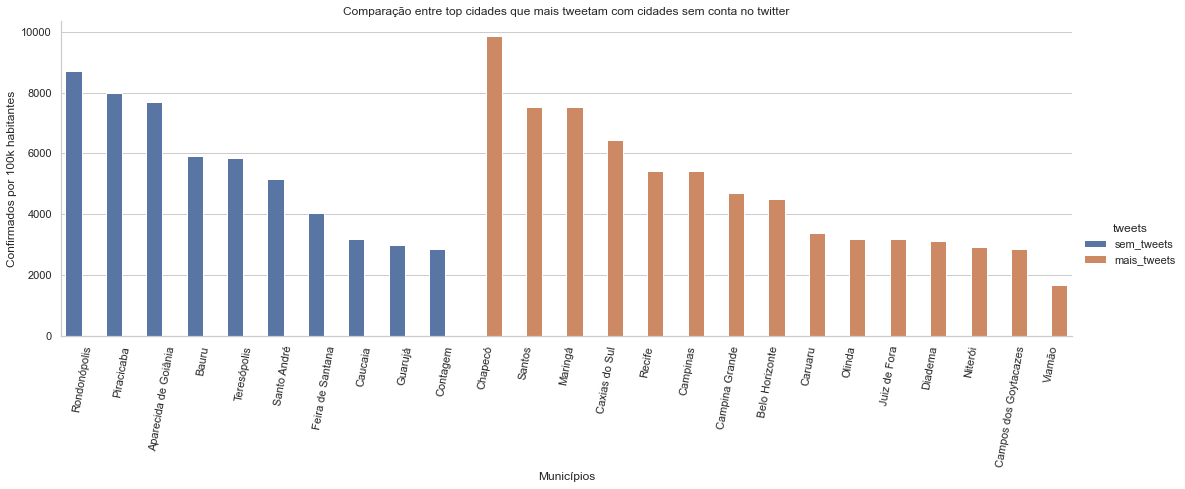

In [260]:
result = result.sort_values(["tweets", 'confirmados_100k'], ascending=False)

sns.factorplot(y='confirmados_100k', x='municipio', hue='tweets', data=result, kind='bar', ax=ax, height=5, aspect=3)
plt.xlabel("Municípios")
plt.ylabel("Confirmados por 100k habitantes")
plt.xticks(rotation=80)
plt.title("Comparação entre top cidades que mais tweetam com cidades sem conta no twitter")

Text(0.5, 1.0, 'Comparação entre top cidades que mais tweetam com cidades sem conta no twitter')

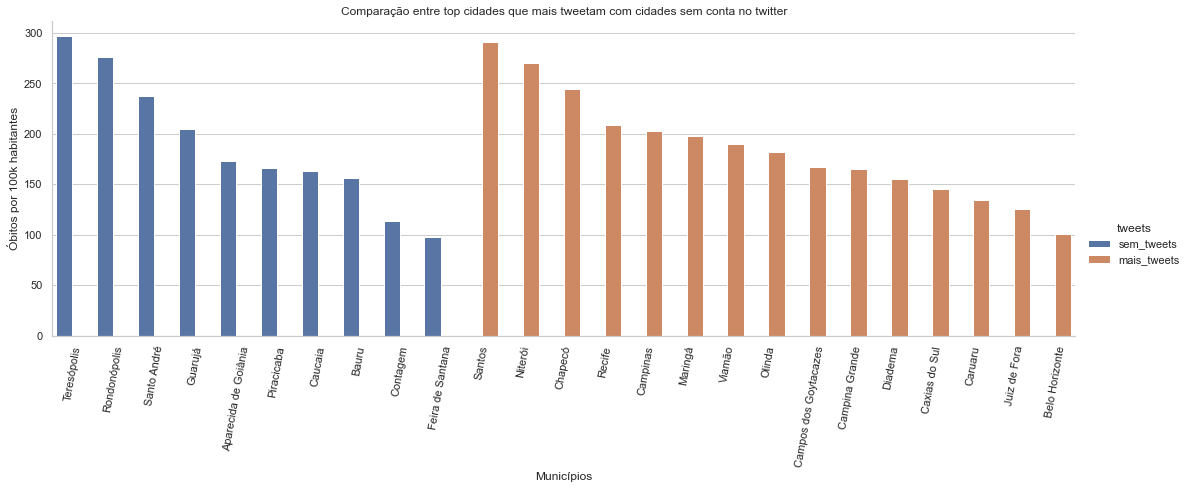

In [261]:
result = result.sort_values(["tweets", 'obitos_100k'], ascending=False)

sns.factorplot(y='obitos_100k', x='municipio', hue='tweets', data=result, kind='bar', ax=ax, height=5, aspect=3)
plt.xlabel("Municípios")
plt.ylabel("Óbitos por 100k habitantes")
plt.xticks(rotation=80)
plt.title("Comparação entre top cidades que mais tweetam com cidades sem conta no twitter")

### Resposta: Podemos perceber que para prefeituras que nao possuem conta no twitter os numeros de casos confirmados e obitos por 100 k habitantes e bem semelhante.

### 3. Quais os tópicos mais utilizados pelas prefeituras nos tweets quando a pandemia teve o maior número de casos confirmados/óbitos?

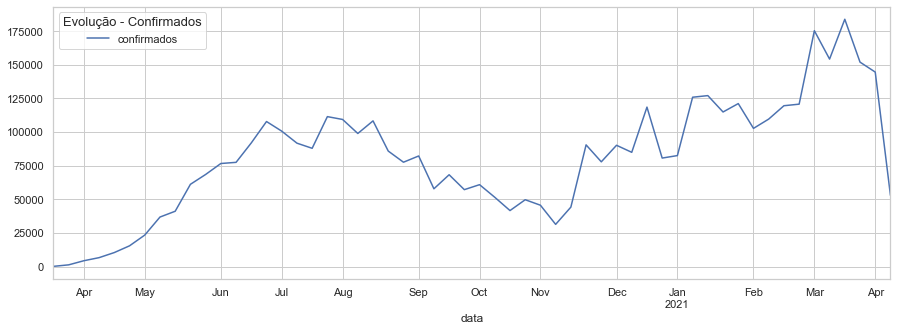

In [262]:
# Identifcando quando houve um aumento de casos da pandemia.

df['data'] = pd.to_datetime(df['data'])
covid_m = df['data'].dt.to_period("W")

dfc = df.groupby([covid_m])["confirmados", "obitos"].sum()
dfc.drop('obitos', axis=1, inplace=True)

dfd = df.groupby([covid_m])["confirmados", "obitos"].sum()
dfd.drop('confirmados', axis=1, inplace=True)

dfc.plot(figsize=(15,5)).legend(title="Evolução - Confirmados", fontsize=11, title_fontsize=13)

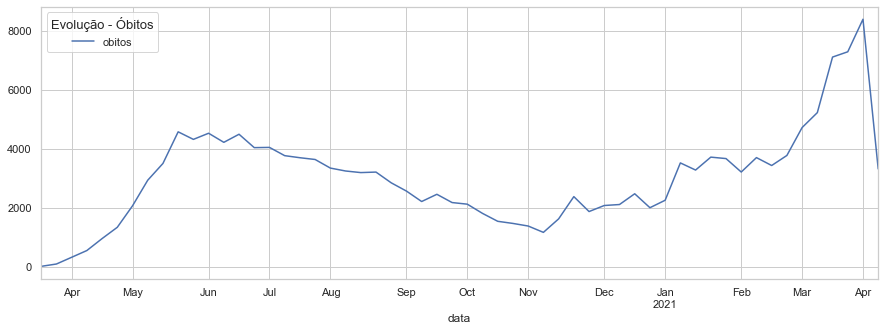

In [263]:
dfd.plot(figsize=(15,5)).legend(title="Evolução - Óbitos", fontsize=11, title_fontsize=13)

### No caso de CASOS CONFIRMADOS e OBITOS vamos pegar os seguintes períodos: Mês de Maio - 2020, Mês de Junho - 2020, 15 de Novembro ate 1 de Abril - 2021

## Casos confirmados e obitos - Analise de topicos de todas as prefeituras quando houve aumento de casos

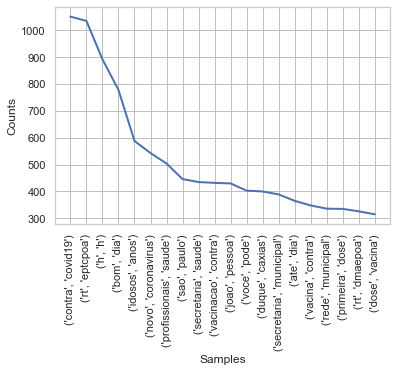

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [264]:
df_geral = df_merge_tt[(df_merge_tt.created_at > '2020-05-01') & (df_merge_tt.created_at <= '2020-05-31')]
df_confirmados = df_merge_tt[(df_merge_tt.created_at > '2020-06-01') & (df_merge_tt.created_at <= '2020-06-30')]
df_obitosNov = df_merge_tt[(df_merge_tt.created_at > '2020-11-15') & (df_merge_tt.created_at <= '2021-04-01')]

df_geral = df_geral.append(df_confirmados)
df_geral = df_geral.append(df_obitosNov)

# Agrupamentos e união dos textos por estado
df_estados = df_geral.groupby('estado')['tokens_frase'].apply(lambda x: ' '.join(x))

texto_geral = ""

for estado, texto in df_estados.items():
    texto_geral = texto_geral + " " + texto

freqDist = FreqDist(nltk.bigrams(texto_geral.split(" ")))
freqDist.plot(20)

[nltk_data] Downloading package stopwords to C:\Users\Mary
[nltk_data]     Camila\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


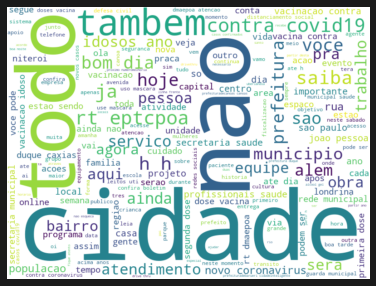

In [265]:
from nltk.corpus import stopwords
nltk.download('stopwords')

stopwords = set(stopwords.words('portuguese'))

wordcloud = WordCloud(stopwords= stopwords, background_color="white",width=800, height=600).generate(texto_geral)

# Exibe a imagem gerada
plt.figure( figsize=(10, 5), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Agora vamos separar os tweets entre os estados e vamos ver o que cada estado tweetou quando tivemos os picos de casos confirmados na pandemia 

Estado ES 


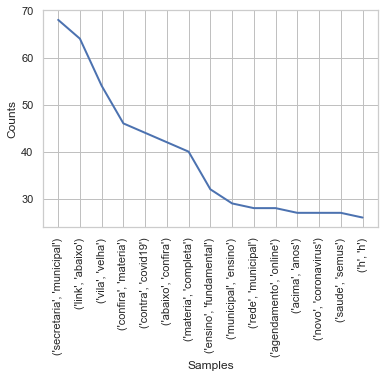

Estado MG 


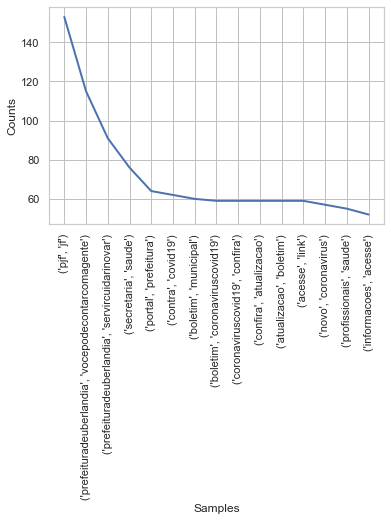

Estado PB 


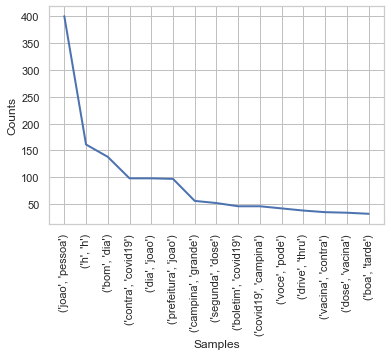

Estado PE 


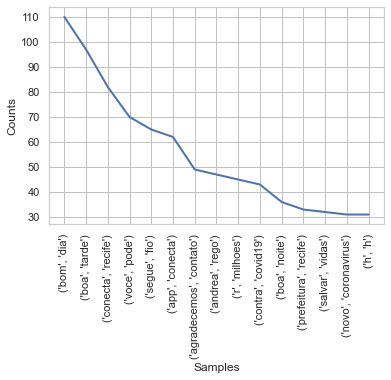

Estado PR 


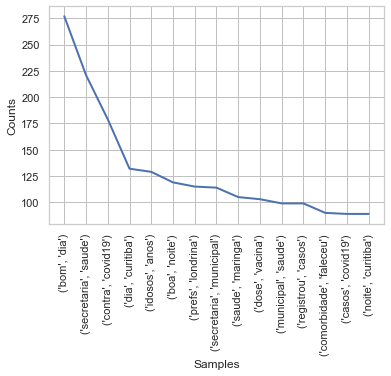

Estado RJ 


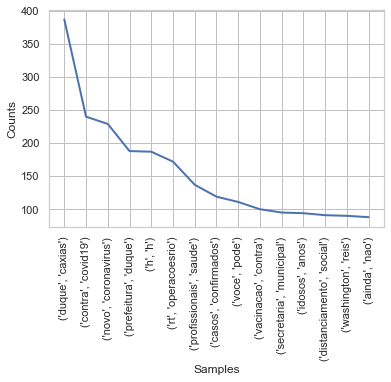

Estado RS 


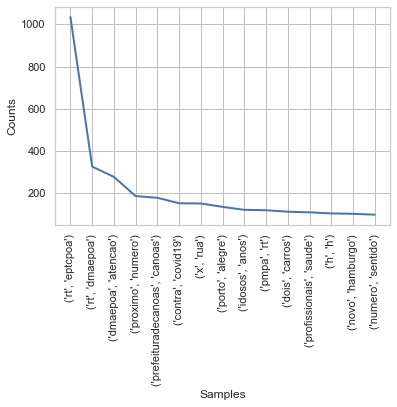

Estado SC 


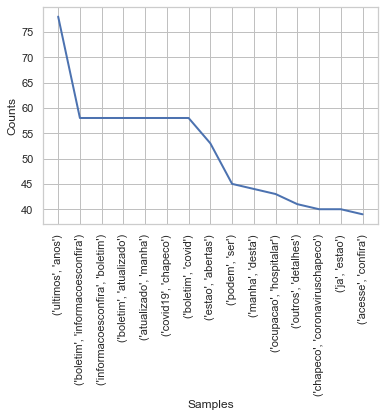

Estado SP 


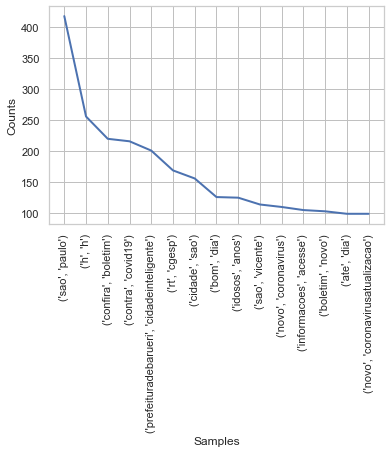

In [266]:
for estado, texto in df_estados.items():
    print("Estado {} ".format(estado))
    freqDist = FreqDist(nltk.bigrams(texto.split(" ")))
    freqDist.plot(15)

[nltk_data] Downloading package stopwords to C:\Users\Mary
[nltk_data]     Camila\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Estado ES 


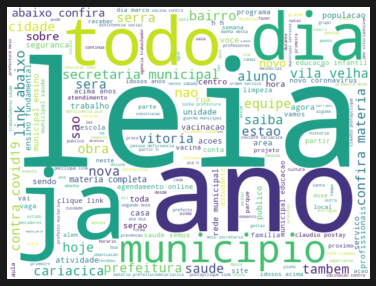

Estado MG 


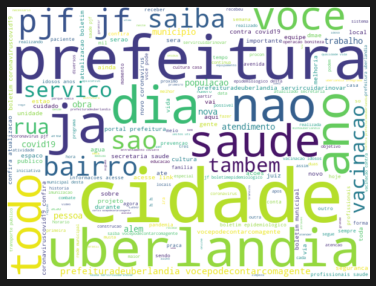

Estado PB 


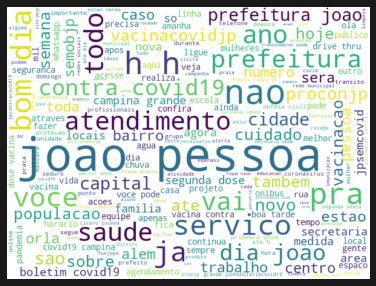

Estado PE 


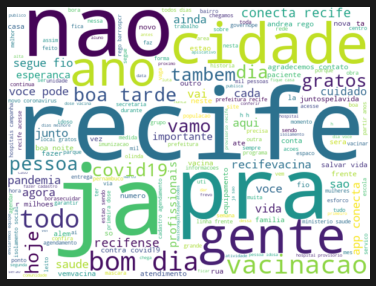

Estado PR 


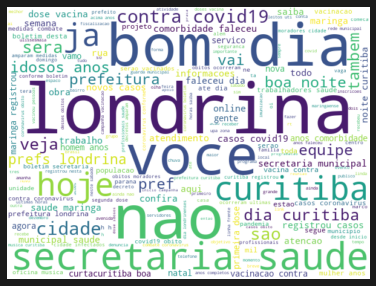

Estado RJ 


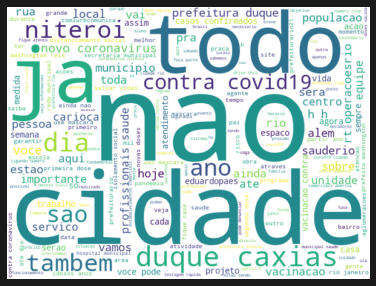

Estado RS 


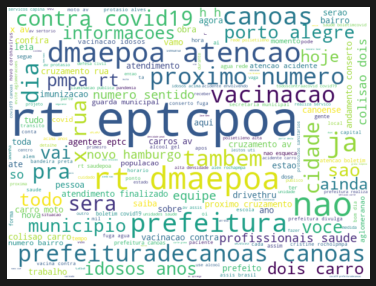

Estado SC 


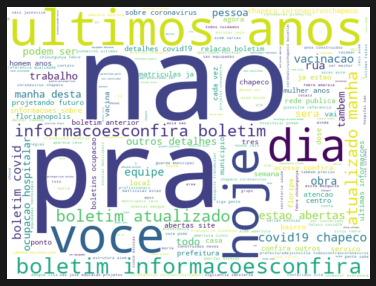

Estado SP 


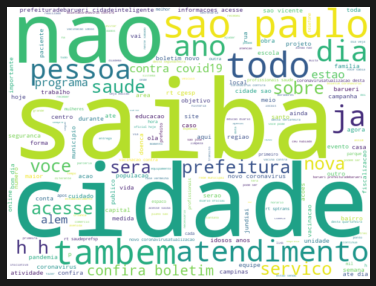

In [267]:
from nltk.corpus import stopwords
nltk.download('stopwords')

stopwords = set(stopwords.words('portuguese'))

for estados, texto in df_estados.items():
    print("Estado {} ".format(estados))
    # Cria a imagem da nuvem de palavras:
    wordcloud = WordCloud(stopwords= stopwords, background_color="white",width=600, height=450).generate(texto)

    # Exibe a imagem gerada
    plt.figure( figsize=(10, 5), facecolor='k')
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

### Resposta: Observando as wordclouds e a frequencia das palavras podemos ver os topicos mais publicados quando tivemos um aumento de casos de covid. 

### 4. Quais os tópicos mais utilizados pelas prefeituras nos tweets quando a pandemia teve uma diminuição do número de casos confirmados/óbitos?

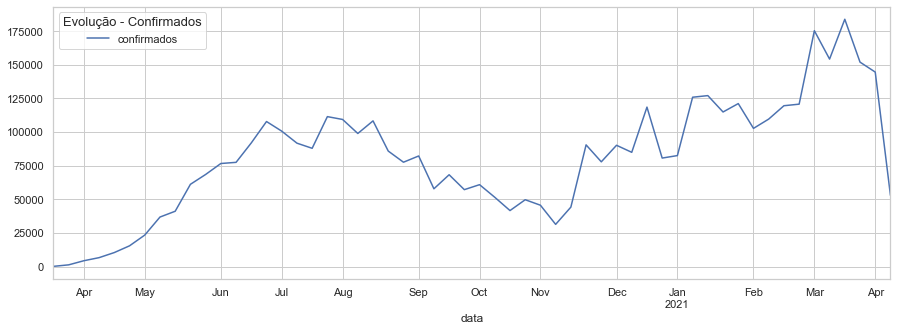

In [268]:
dfc.plot(figsize=(15,5)).legend(title="Evolução - Confirmados", fontsize=11, title_fontsize=13)

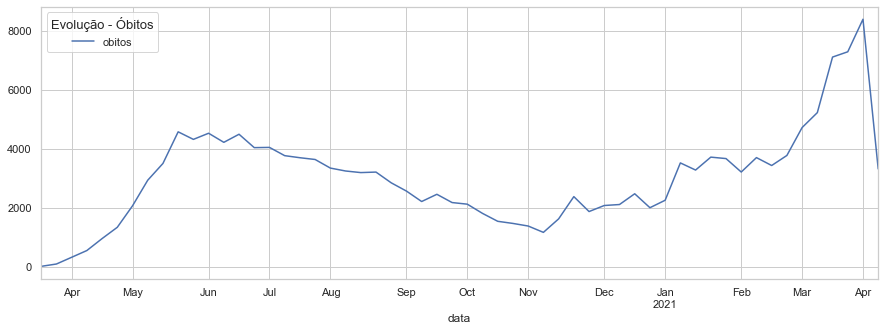

In [269]:
dfd.plot(figsize=(15,5)).legend(title="Evolução - Óbitos", fontsize=11, title_fontsize=13)

### No caso de CASOS CONFIRMADOS vamos pegar os seguintes períodos: 15 de agosto a 15 de Novembro - 2020

### No caso de ÓBITOS vamos pegar os seguintes períodos: Julho ate Novembro - 2020

## Casos confirmados e Obitos - Analise de topicos de todas as prefeituras quando houve diminuição de casos

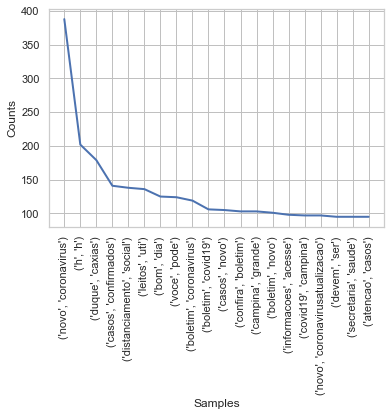

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [270]:
df_geral = df_merge_tt[(df_merge_tt.created_at > '2020-06-01') & (df_merge_tt.created_at <= '2020-11-15')]

# Agrupamentos e união dos textos por estado
df_estados = df_geral.groupby('estado')['tokens_frase'].apply(lambda x: ' '.join(x))

texto_geral = ""

for estado, texto in df_estados.items():
    texto_geral = texto_geral + " " + texto

freqDist = FreqDist(nltk.bigrams(texto_geral.split(" ")))
freqDist.plot(20)

[nltk_data] Downloading package stopwords to C:\Users\Mary
[nltk_data]     Camila\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


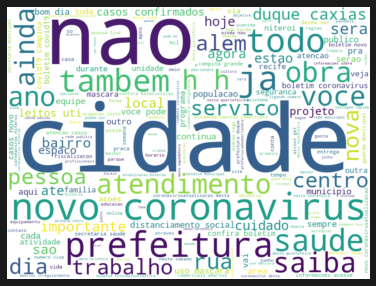

In [271]:
from nltk.corpus import stopwords
nltk.download('stopwords')

stopwords = set(stopwords.words('portuguese'))

wordcloud = WordCloud(stopwords= stopwords, background_color="white",width=800, height=600).generate(texto_geral)

# Exibe a imagem gerada
plt.figure( figsize=(10, 5), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Agora vamos separar os tweets entre os estados e vamos ver o que cada estado tweetou quando tivemos uma dimunição de casos confirmados na pandemia 

Estado MG 


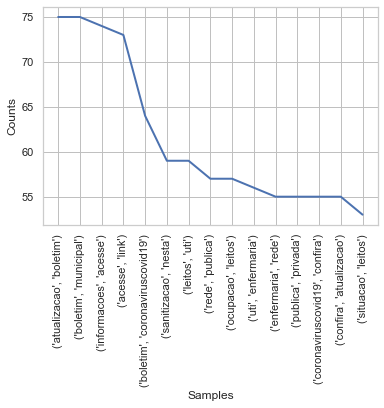

Estado PB 


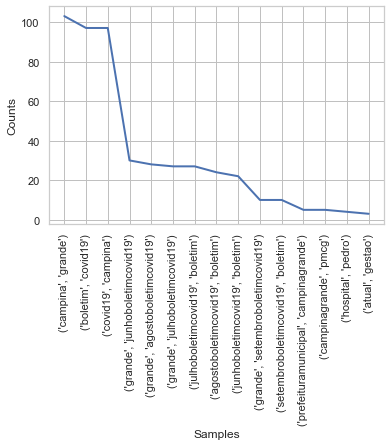

Estado PE 


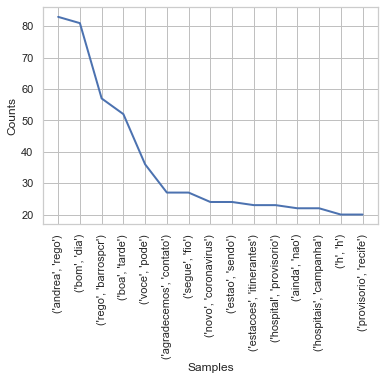

Estado RJ 


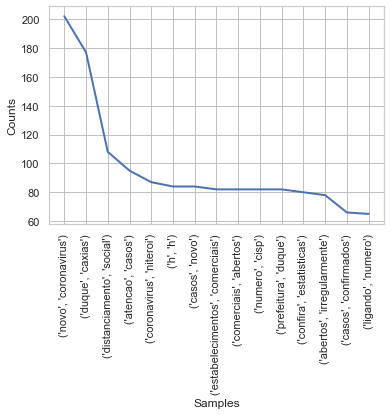

Estado RS 


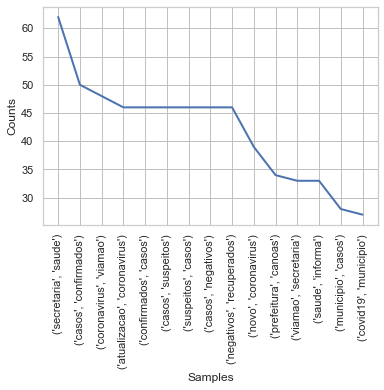

Estado SC 


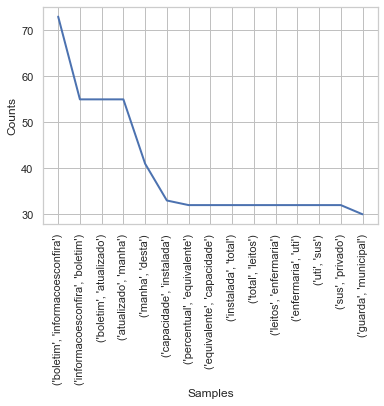

Estado SP 


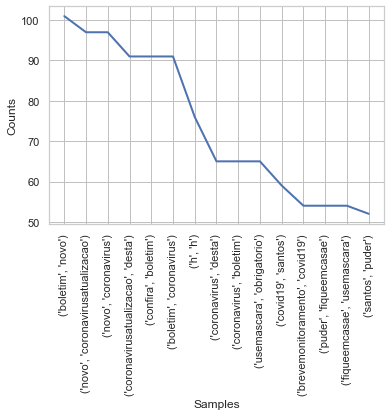

In [272]:
for estado, texto in df_estados.items():
    print("Estado {} ".format(estado))
    freqDist = FreqDist(nltk.bigrams(texto.split(" ")))
    freqDist.plot(15)

[nltk_data] Downloading package stopwords to C:\Users\Mary
[nltk_data]     Camila\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Estado MG 


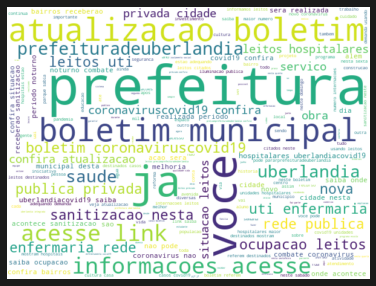

Estado PB 


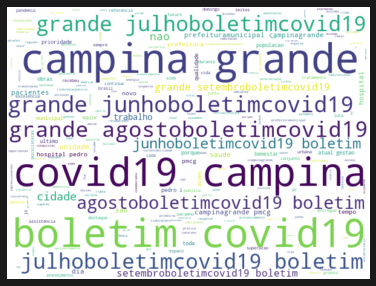

Estado PE 


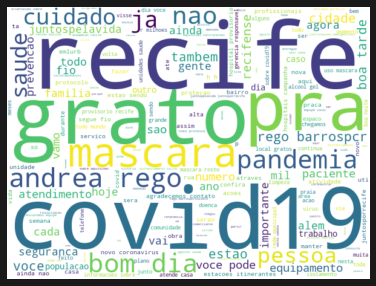

Estado RJ 


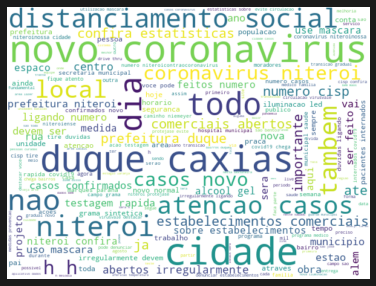

Estado RS 


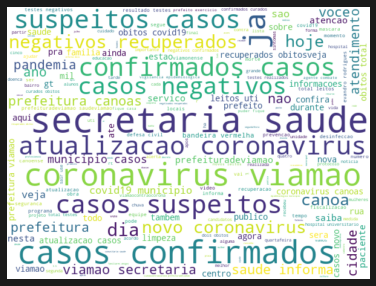

Estado SC 


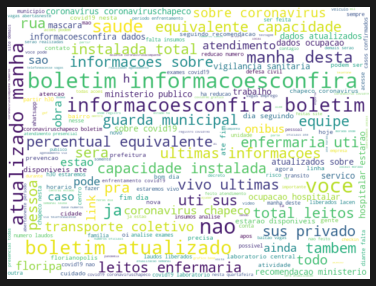

Estado SP 


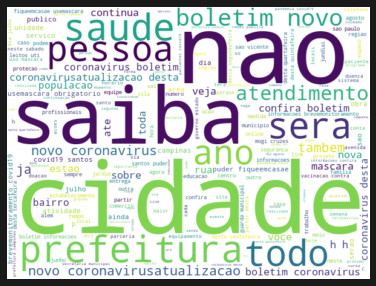

In [273]:
from nltk.corpus import stopwords
nltk.download('stopwords')

stopwords = set(stopwords.words('portuguese'))

for estados, texto in df_estados.items():
    print("Estado {} ".format(estados))
    # Cria a imagem da nuvem de palavras:
    wordcloud = WordCloud(stopwords= stopwords, background_color="white",width=600, height=450).generate(texto)

    # Exibe a imagem gerada
    plt.figure( figsize=(10, 5), facecolor='k')
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

### Resposta: observando as wordclouds e a frequencia das palavras podemos ver que quando houve uma diminuição dos casos houve mais tweets com termos relacionados a covid. 

### 5. Qual a evolução dos tópicos dos tweets das prefeituras mensalmente e estes tópicos se relacionam com uma alta/baixa de número de casos confirmados de COVID-19?

In [274]:
## Preparando o corpus com todos os tweets
clean_text = []
for list_texto in df_merge_tt['final_tokens']:
    list_token = []
    for word in list_texto:
        list_token.append(word.replace("'", ""))
    clean_text.append(list_token)

In [275]:
def prepare_corpus(doc_clean):
    dictionary = corpora.Dictionary(doc_clean)
    ## Convertendo para bag of words map token to id
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    return dictionary,doc_term_matrix


def create_gensim_lsa_model(doc_clean,number_of_topics,words):
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    lsamodel = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
    # print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))
    return lsamodel

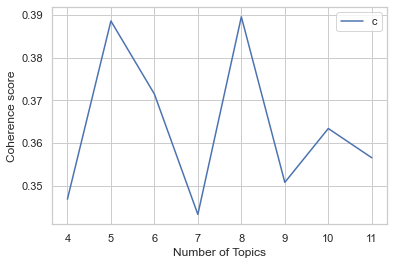

In [276]:
def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LSA model
        model = LsiModel(doc_term_matrix, num_topics=num_topics, id2word = dictionary)  # train model
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values


def plot_graph(doc_clean,start, stop, step):
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix,doc_clean,
                                                            stop, start, step)
    # Show graph
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()
    
    
start,stop,step=4,12,1
plot_graph(clean_text,start,stop,step)

In [277]:
# LSA Model
number_of_topics=8
words=8
model=create_gensim_lsa_model(clean_text,number_of_topics,words)
topics = model.print_topics(num_topics=number_of_topics, num_words=words)
topics

[(0,
  '0.247*"saud" + 0.223*"nov" + 0.211*"covid19" + 0.210*"nao" + 0.188*"tod" + 0.177*"cas" + 0.175*"vacin" + 0.167*"ser"'),
 (1,
  '-0.391*"vacin" + -0.284*"dos" + 0.278*"cas" + -0.266*"idos" + -0.259*"vacinaca" + -0.244*"anos" + 0.232*"coronavirus" + -0.224*"h"'),
 (2,
  '0.700*"h" + -0.215*"covid19" + -0.209*"saud" + -0.201*"vacin" + -0.192*"coronavirus" + 0.169*"ser" + 0.166*"dia" + -0.159*"nov"'),
 (3,
  '-0.515*"nao" + 0.373*"h" + 0.300*"nov" + 0.225*"boletim" + 0.204*"coronavirus" + -0.184*"tod" + -0.166*"voc" + -0.162*"pod"'),
 (4,
  '-0.307*"h" + -0.288*"cas" + -0.273*"nao" + 0.269*"saud" + 0.240*"prefeitur" + -0.215*"coronavirus" + 0.180*"municipal" + -0.179*"nov"'),
 (5,
  '-0.408*"nov" + 0.401*"saud" + -0.370*"dia" + 0.267*"h" + -0.217*"rt" + 0.206*"covid19" + 0.193*"tod" + -0.180*"ser"'),
 (6,
  '-0.386*"nov" + 0.372*"pod" + -0.306*"tod" + 0.273*"voc" + 0.271*"ser" + -0.249*"cidad" + 0.238*"boletim" + 0.173*"saud"'),
 (7,
  '-0.586*"rt" + -0.380*"eptcpo" + -0.304*"av" +

## Filtrando somente quando houve DIMINUIÇÃO dos casos

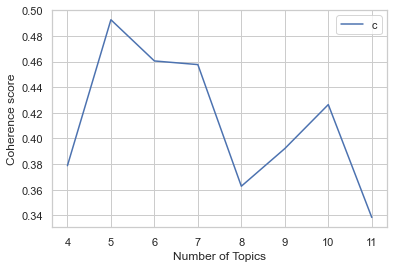

In [278]:
## Filtrando somente quando houve DIMINUIÇÃO dos casos
df_geral = df_merge_tt[(df_merge_tt.created_at > '2020-06-01') & (df_merge_tt.created_at <= '2020-11-15')]

## Preparando o corpus com todos os tweets
clean_text = []
for list_texto in df_geral['final_tokens']:
    list_token = []
    for word in list_texto:
        list_token.append(word.replace("'", ""))
    clean_text.append(list_token)
    
plot_graph(clean_text,start,stop,step)

In [279]:
# LSA Model
number_of_topics=5
words=8
model=create_gensim_lsa_model(clean_text,number_of_topics,words)
topics = model.print_topics(num_topics=number_of_topics, num_words=words) 

topics

[(0,
  '-0.308*"cas" + -0.303*"nov" + -0.287*"coronavirus" + -0.259*"covid19" + -0.188*"nest" + -0.166*"saud" + -0.164*"nao" + -0.158*"cidad"'),
 (1,
  '-0.536*"cas" + 0.334*"h" + -0.312*"coronavirus" + 0.246*"nest" + -0.195*"confirm" + -0.170*"nov" + 0.135*"ser" + -0.133*"numer"'),
 (2,
  '0.405*"leit" + 0.386*"boletim" + -0.246*"masc" + 0.241*"nest" + -0.224*"nao" + 0.182*"covid19" + 0.176*"uti" + 0.168*"hospital"'),
 (3,
  '0.509*"nov" + 0.405*"h" + -0.301*"masc" + -0.288*"nao" + -0.263*"covid19" + -0.179*"leit" + -0.131*"voc" + -0.105*"pod"'),
 (4,
  '-0.420*"cas" + 0.357*"boletim" + -0.330*"h" + 0.250*"dest" + 0.248*"nov" + 0.212*"informaco" + -0.182*"saud" + 0.179*"conf"')]

## Filtrando somente quando houve AUMENTO dos casos

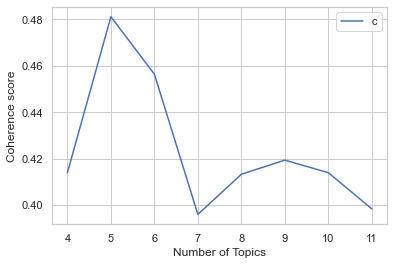

In [280]:
## Filtrando somente quando houve AUMENTO dos casos

df_geral = df_merge_tt[(df_merge_tt.created_at > '2020-05-01') & (df_merge_tt.created_at <= '2020-05-31')]
df_confirmados = df_merge_tt[(df_merge_tt.created_at > '2020-06-01') & (df_merge_tt.created_at <= '2020-06-30')]
df_obitosNov = df_merge_tt[(df_merge_tt.created_at > '2020-11-15') & (df_merge_tt.created_at <= '2021-04-01')]

df_geral = df_geral.append(df_confirmados)
df_geral = df_geral.append(df_obitosNov)

clean_text = []
for list_texto in df_geral['final_tokens']:
    list_token = []
    for word in list_texto:
        list_token.append(word.replace("'", ""))
    clean_text.append(list_token)
    
plot_graph(clean_text,start,stop,step)

In [281]:
# LSA Model
number_of_topics=5
words=8
model=create_gensim_lsa_model(clean_text,number_of_topics,words)
topics = model.print_topics(num_topics=number_of_topics, num_words=words) 

topics

[(0,
  '0.241*"saud" + 0.222*"vacin" + 0.210*"nao" + 0.203*"nov" + 0.201*"covid19" + 0.192*"tod" + 0.167*"h" + 0.162*"ser"'),
 (1,
  '-0.411*"vacin" + 0.299*"nao" + -0.295*"dos" + -0.291*"idos" + -0.261*"anos" + -0.241*"vacinaca" + 0.204*"cas" + -0.186*"saud"'),
 (2,
  '-0.744*"h" + 0.215*"saud" + 0.215*"nov" + 0.182*"covid19" + 0.180*"coronavirus" + -0.172*"ser" + -0.170*"dia" + 0.169*"cas"'),
 (3,
  '0.526*"nao" + -0.361*"nov" + -0.212*"rt" + 0.200*"vacin" + 0.184*"tod" + -0.183*"h" + -0.170*"coronavirus" + -0.157*"cas"'),
 (4,
  '0.603*"rt" + 0.377*"eptcpo" + 0.299*"av" + 0.218*"rua" + -0.218*"h" + 0.160*"proxim" + -0.145*"nov" + 0.131*"x"')]

## Começando a analise de topicos mensais

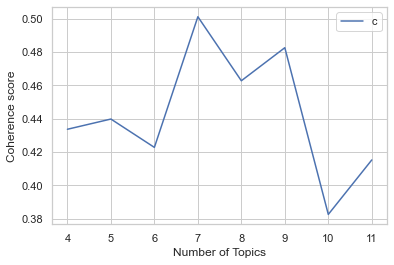

In [282]:
df_geral = df_merge_tt[(df_merge_tt.created_at > '2021-03-01') & (df_merge_tt.created_at <= '2021-03-31')]

clean_text = []
for list_texto in df_geral['final_tokens']:
    list_token = []
    for word in list_texto:
        list_token.append(word.replace("'", ""))
    clean_text.append(list_token)
    
plot_graph(clean_text,start,stop,step)

In [283]:
# LSA Model
number_of_topics=7
words=5
model=create_gensim_lsa_model(clean_text,number_of_topics,words)
topics = model.print_topics(num_topics=number_of_topics, num_words=words) 

topics

[(0,
  '-0.331*"vacin" + -0.300*"dos" + -0.259*"idos" + -0.251*"anos" + -0.237*"vacinaca"'),
 (1,
  '-0.313*"vacin" + 0.308*"h" + -0.302*"dos" + -0.279*"idos" + 0.236*"nao"'),
 (2,
  '0.824*"h" + -0.187*"nao" + -0.155*"tod" + -0.145*"covid19" + 0.128*"anos"'),
 (3, '0.531*"rt" + 0.419*"eptcpo" + 0.316*"av" + 0.273*"rua" + -0.186*"nao"'),
 (4,
  '0.398*"anos" + -0.364*"vacin" + 0.357*"dia" + 0.284*"vacinaca" + -0.263*"dos"'),
 (5,
  '-0.435*"covid19" + -0.371*"saud" + 0.325*"dia" + 0.315*"nao" + -0.183*"nov"'),
 (6,
  '-0.502*"nao" + 0.459*"dia" + -0.324*"vacinaca" + -0.246*"anos" + -0.207*"idos"')]

In [284]:
df_list = pd.DataFrame(index=ts.index, columns=["A", "B", "C", "D"])

AttributeError: 'LsiModel' object has no attribute 'log_perplexity'

### 6. Prefeituras que têm um maior engajamento no Twitter teriam menor número de casos confirmados/óbitos?

In [151]:
# lê o arquivo CSV
df_tweets_eng = pd.read_csv('datasets/PrefsTweetsPorConfirmadosEng.csv', delimiter=";")

df_tweets_eng.drop('Unnamed: 0', axis=1, inplace=True)

df_tweets_eng.rename(columns={'estado_x':'estado', 'Count':'qtde_tweets', 'Count_c':'qtde_tweets_covid'}, 
                 inplace=True)

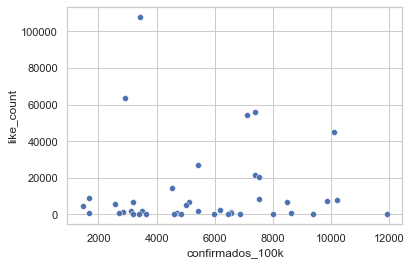

In [158]:
g = sns.scatterplot(data=df_tweets_eng, x="confirmados_100k", y="like_count")

## Resposta: Analisando todos os tweets (covid e outros assuntos) e o enjamento dos usuarios de forma geral, prefeituras que possuem um maior enajamento no twitter tendem a ter um maior numero de casos confirmados e obitos

In [239]:
# lê o arquivo CSV
df_topics_mes = pd.read_csv('datasets/topicsMensais.csv', delimiter=";")
df_topics_mes

palavra        data
0    coronavirus  2020-04-01
1            cas  2020-04-01
2            nov  2020-04-01
3           saud  2020-04-01
4        covid19  2020-04-01
..           ...         ...
309          nao  2021-03-01
310          dia  2021-03-01
311     vacinaca  2021-03-01
312         anos  2021-03-01
313         idos  2021-03-01

[314 rows x 2 columns]

<AxesSubplot:xlabel='data', ylabel='Count'>

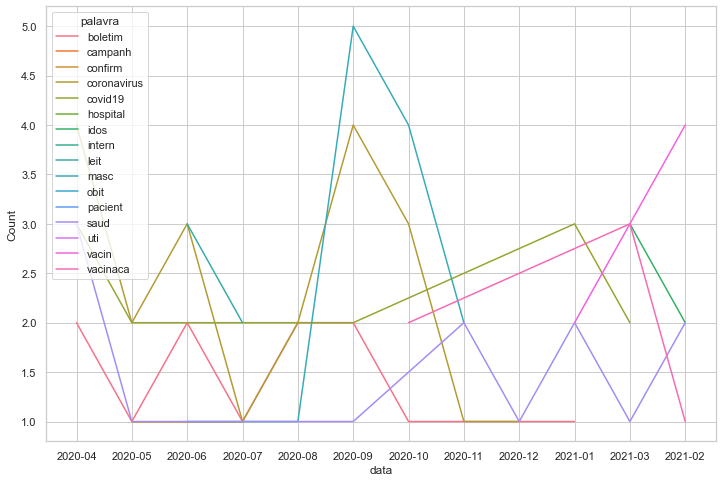

In [247]:
lista_topics_covid = ["coronavirus", "covid19", "saud", "boletim", "masc", "confirm", "leit", "hospital", "uti", "obit", "pacient", "intern","vacinaca", "campanh", "vacin", "idos"]
df_topics_mes['data'] = pd.to_datetime(df_topics_mes['data'])
df_topics_mes['data'] = df_topics_mes['data'].dt.strftime('%Y-%m')

df_topics_mes = df_topics_mes[df_topics_mes['palavra'].isin(lista_topics_covid)]

dfc = df_topics_mes.groupby(["palavra","data"]).size().reset_index(name="Count")
fig = plt.figure(figsize=(12,8))
sns.lineplot(data=dfc, x="data", y="Count", hue="palavra")

<AxesSubplot:xlabel='data', ylabel='obitos'>

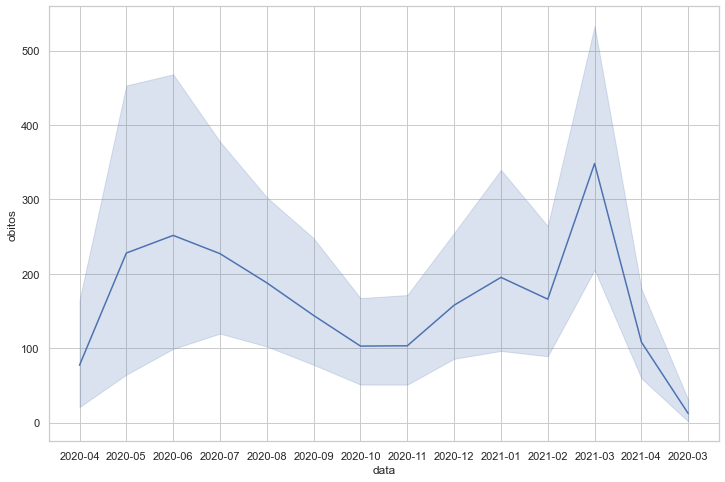

In [264]:
df_municipio = df_merge_tt.groupby(['estado', 'municipio']).size().reset_index(name="Count").sort_values('Count', ascending=False)
list_mun_tweets = df_municipio[['estado','municipio']]

df_time = df.groupby(['estado',"municipio", "populacao", "data"])["confirmados", "obitos"].sum().reset_index()
df_time = df_time[df_time['municipio'].isin(list_mun_tweets['municipio'])]
df_time = df_time[df_time.set_index(['estado','municipio']).index.isin(list_mun_tweets.set_index(['estado','municipio']).index)]
df_time.drop('estado', axis=1, inplace=True)
df_time.drop('municipio', axis=1, inplace=True)
df_time.drop('populacao', axis=1, inplace=True)

df_time['data'] = pd.to_datetime(df_time['data'])
df_time['data'] = df_time['data'].dt.strftime('%Y-%m')

fig = plt.figure(figsize=(12,8))
sns.lineplot(data=df_time, x="data", y="obitos")

In [ ]:
## Agora ja tenho somente a parte com os municipios que estao na minha listagem

<AxesSubplot:label='31809d40-aa7a-4a72-9d91-40228a82baaa', xlabel='data', ylabel='confirmados'>

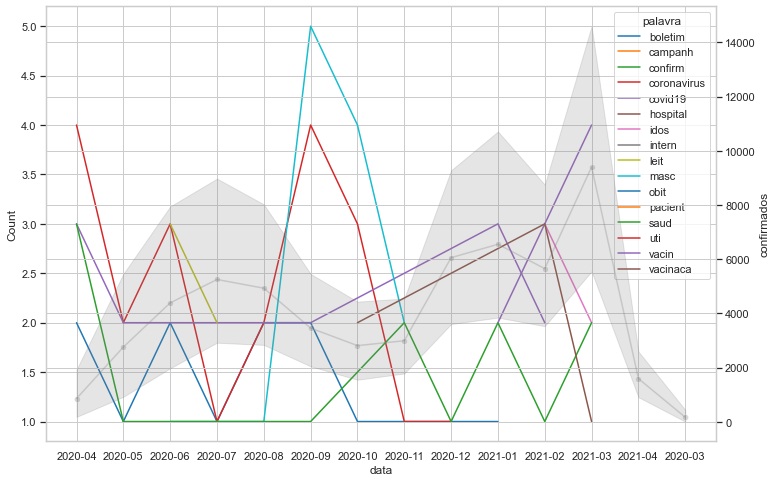

In [302]:
fig = plt.figure(figsize=(12,8))
sns.lineplot(data=dfc, x="data", y="Count", hue="palavra",palette="tab10", linewidth=1.5)
ax2 = plt.twinx()
sns.lineplot(data=df_time, x="data", y="confirmados",  ax=ax2, color='gray',marker = 'o', alpha=0.3)